# Fase 7 EDR: Signal Feature extraction
 
Al fin y al cabo lo que estamos buscando es eficiencia en los aterrzajes. Podemos analizar partes de la `serie temporal` que es cada experimento, y sacar variables significativas, como cuanta desviación hay en el eje x, velocidad en el momento del aterrizaje, etc.
 
Atributos a implementar:

1. No sean extremadamente largos
2. Si acaso consiguen terminar aterrizar
3. Tengan poca variabilidad en el eje x (calcular la variación de X sobre la posición inicial que es cero)
4. La posición de Y debe terminar en cero
5. La velocidad angular 
6. Analizar la posición de la nave respecto a x antes y después del aterrizaje. Cualquier variación tras haber tocado el suelo probablemente implica baja eficiencia. La idea es mantenerse en 0 o alcanzar esa posición antes de tocar el suelo.
7. En el caso de posiciones de x con comportaminetos extraños, quizá podemos reconstruir los cambios de posición usando la velocidad y un ODE. (La velocidad es la derivada de la función de la posición)
8. Utilizar los outputs de `getLandedExperiments.py` para crear una variable que indique si el experimento ha aterrizado correctamente o no.
9. <span style="color:red">Dudoso:</span> Suavidad en las funciones de aceleración

## Cosas que estudiar

* Ver cómo acaban los experimentos que no aterrizan
* Mejorar la smooth function, cuando la Y no cae drásticamente a 0 pero sí a un numero cercano, no se corrige el valor.

### Implementaciones
#### 1. No sean extremadamente largos
Para poder evaluar esto, tenemos que ver los boxplots the cada uno de los experimentos, y sería buena idea que los separasemos por si son capaces de aterrizar o no.
Vamos a sacar si han aterrizado o no usando `fileAggregator.py` y la función `expLanded` de `f7utils.py`.

In [50]:
library(dplyr)
library(ggplot2)

In [51]:
#Remove the duplicate index variable
summarylanded <- read.csv(file = "data/testOscar.csv") %>% select(-X)
summarylanded$lands <- as.factor(summarylanded$lands)
head(summarylanded)

,filename,total_timesteps,gravity,wind_power,turbulence_power,efficiency,lands
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,experiment_1.csv,185,-5.375066,14.337393,1.9027891,415.69,1
2,experiment_2.csv,428,-3.958084,16.376438,1.6979323,104.37,1
3,experiment_4.csv,193,-3.640152,1.614948,0.1922136,411.14,1
4,experiment_5.csv,166,0.000000,0.000000,0.2421779,414.93,1
5,experiment_6.csv,172,-5.289123,15.771525,1.4538064,373.85,0
6,experiment_7.csv,166,-7.079790,16.413726,0.9369702,415.83,1


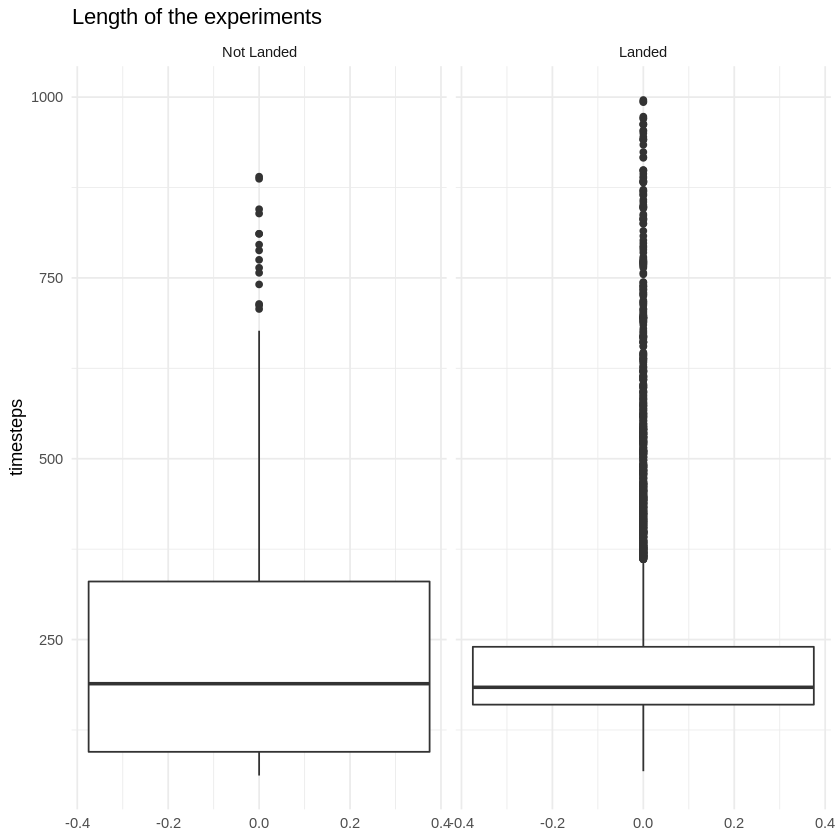

In [52]:
summarylandedbp <- summarylanded
levels(summarylandedbp$lands) <- c("Not Landed", "Landed")

ggplot(summarylandedbp) + aes(y = total_timesteps) +
    geom_boxplot() + facet_wrap(.~lands) + theme_minimal() +
    theme(legend.position = "bottom") +
    labs(title = "Length of the experiments", y = "timesteps")

Como tenemos un problema con los outliers de los casos en los que la nave aterriza en el training set, vamos a hacer primero una comparativa con el testing set para ver si es significante.

In [53]:
summarylandedtesting <- read.csv(file = "data/testOscartestingset.csv") %>% select(-X)
summarylandedtesting$lands <- as.factor(summarylandedtesting$lands)#Remove the duplicate index variable
head(summarylandedtesting)

,filename,total_timesteps,gravity,wind_power,turbulence_power,lands
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,experiment_0.csv,156,-10.363594,9.555678,0.4416887,1
2,experiment_3.csv,252,-2.599651,7.094931,0.7720043,1
3,experiment_8.csv,146,-10.768399,5.744031,0.8987043,1
4,experiment_10.csv,178,-7.815608,19.640269,1.6313483,1
5,experiment_14.csv,193,-3.833533,11.007721,1.5779704,1
6,experiment_19.csv,204,-3.464858,0.000000,1.1071370,1


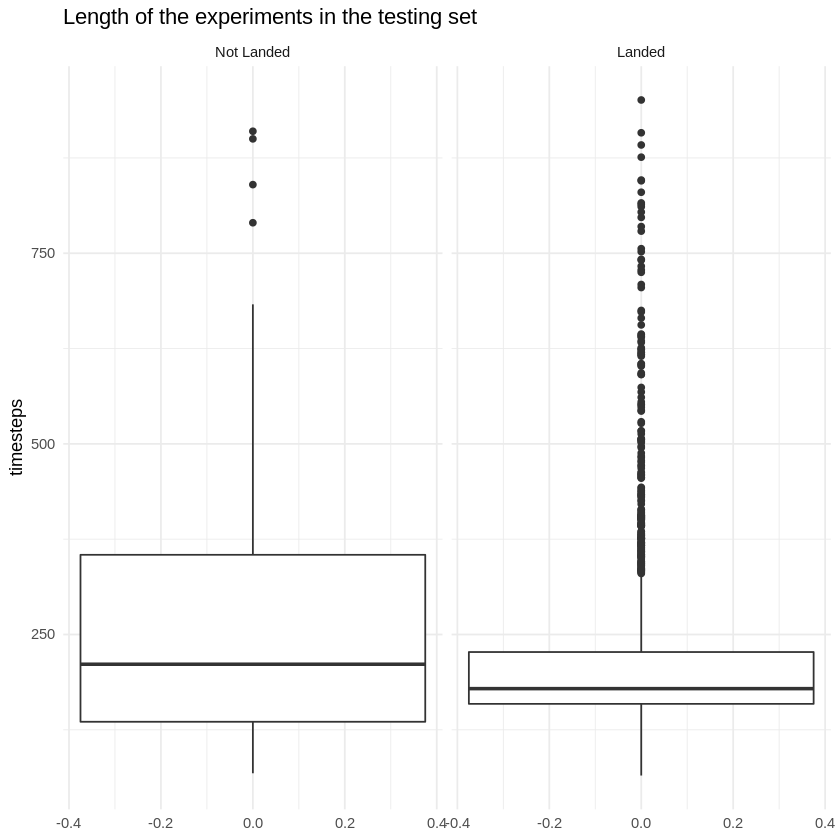

In [54]:
summarylandedbptesting <- summarylandedtesting
levels(summarylandedbptesting$lands) <- c("Not Landed", "Landed")

ggplot(summarylandedbptesting) + aes(y = total_timesteps) +
    geom_boxplot() + facet_wrap(.~lands) + theme_minimal() +
    theme(legend.position = "bottom") +
    labs(title = "Length of the experiments in the testing set", y = "timesteps")

Como podemos ver, la distribucion de ambos train and test sets para los timesteps, es muy parecida, por no decir idéntica, si la diferencia de experimentos entre uno y otro fuera menor. Los boxplots reflejan claramente como tanto los outliers como los no outliers son exactamente iguales en distribución en la comparacion entre training y testing, por lo que debemos tener mucho cuidado a la hora de borrar outliers.

#### Experimento 6
Podemos notar algo extraño en el experimento 6, en el sentido de que tiene una buena marca de eficiencia, pero al parecer no aterriza. 

Vamos a utilizar la función de python `PlotExperiment` para analizar el experimento 6. Para poder usar código de python dentro de R necesitaremos la librería `reticiulate`.

In [56]:
if (!require("reticulate")){
    install.packages("reticulate")
    library(reticulate)
} else {
    library(reticulate)
}

In [81]:
py_run_string('import pandas as pd')
py_run_string('from f7utils import plotExperiment')
py_run_string('exp6 = pd.read_csv("data/train/experiment_6.csv")')
py_run_string("plotExperiment(exp6)")

Como podemos ver, deberíamos también analizar si un experimento ha aterrizado por el hecho de si se quedan ambas `y_vel` y `ang_vel` estables en 0

## Linear regressions
To test the significance of the variables:

In [44]:
summarylandedlm <- summarylanded %>% select(-filename)

mod1 <- lm(data = summarylandedlm, efficiency ~ (.)^2 )

modGood <- lm(data = summarylandedlm,
              efficiency ~ total_timesteps + gravity +
              wind_power + lands +
              total_timesteps * gravity + total_timesteps * wind_power +
              total_timesteps * turbulence_power + total_timesteps * lands +
              gravity * lands + wind_power * lands
)

In [41]:
summary(modGood)


Call:
lm(formula = efficiency ~ total_timesteps + gravity + wind_power + 
    lands + total_timesteps * gravity + total_timesteps * wind_power + 
    total_timesteps * turbulence_power + total_timesteps * lands + 
    gravity * lands + wind_power * lands, data = summarylandedlm)

Residuals:
    Min      1Q  Median      3Q     Max 
-3961.6    -6.9     5.4    15.5   767.4 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                      118.959963  21.847725   5.445 5.31e-08 ***
total_timesteps                   -0.670299   0.055079 -12.170  < 2e-16 ***
gravity                           -6.989877   1.850409  -3.777 0.000159 ***
wind_power                        -5.946961   1.017413  -5.845 5.23e-09 ***
lands1                           312.119665  20.497277  15.227  < 2e-16 ***
turbulence_power                   0.660696   5.902864   0.112 0.910883    
total_timesteps:gravity           -0.060272   0.006041  -9.977  < 2e-16 ***
to

```python
def stdXdeviation(exp: pd.DataFrame) -> NDArray:
    var = sum(exp.x_pos**2)/(exp.shape[0]-1)
    return np.sqrt(var)
```